In [2]:
import os
import cv2 as cv
import sys
import time
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [3]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback() 

In [4]:
# Get Training Data (Original+Mask) DONT RUN IN THIS CODE 
# Dataset 1: HGR
TRAIN_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/original_images/']
MASK_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 4: Pratheepan
TRAIN_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
MASK_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
train_ids2.sort()
mask_ids2.sort()
TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TRAIN_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/original_images/']
MASK_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 6: SFA
TRAIN_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/original_images/']
MASK_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Dataset 2: TDSD
TRAIN_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/original_images/']
MASK_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/skin_masks/']
train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
train_ids5.sort()
mask_ids5.sort()
TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
MASK_PATH5 = MASK_PATH5*len(train_ids5)

# Dataset 3: Schmugge
TRAIN_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/original_images/']
MASK_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
train_ids6.sort()
mask_ids6.sort()
TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
MASK_PATH6 = MASK_PATH6*len(train_ids6)

# Combine everything
TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5,TRAIN_PATH6))
MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6))
train_ids = np.concatenate((train_ids1,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6))
mask_ids = np.concatenate((mask_ids1,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6))

In [5]:
 # Extract Features and Corresponding Labels (RUN ONCE ONLY TO GET THE DATA)
print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = TRAIN_PATH[0] + train_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MASK_PATH[0] + mask_ids[0]
img = imread(path)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MASK_PATH[n] + mask_ids[n]
    img = imread(path)
    if n in range(899,977):
        img = img[:,:,1]
        
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))

Getting features and labels from images unreshaped... 


NameError: name 'IMG_CHANNELS' is not defined

In [3]:
# Load the data NON SHUFFLED
dat = np.load("ALLFEATURES-Copy1.npy")
print(dat.shape)

(854328232, 10)


In [13]:
# Shuffle the data DON'T RUN
#np.random.shuffle(dat)
dat = np.load('SHUFFLED.npy')

In [13]:
# Load Shuffled data
dat = np.load('SHUFFLED.npy')
feat = dat[0:2000000,0:9]
labels = dat[0:2000000,9]
labels = (labels > 0).astype(np.uint8)
print(feat.shape)
print(labels.shape)

(2000000, 9)
(2000000,)


In [14]:
# Build the network
model = Sequential()
model.add(Dense(9, input_dim=9, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(1, activation='sigmoid'))

checkpointer = ModelCheckpoint('model-extra256layer+moredata-10Feb2019.h5', verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

results = model.fit(feat, labels, validation_split=0.25, epochs=50, batch_size=64, shuffle=True, 
          callbacks=[checkpointer, cb])

Train on 1500000 samples, validate on 500000 samples
Epoch 1/50
1500000/1500000 [==============================] - 157s 105us/step - loss: 0.2665 - acc: 0.8966 - val_loss: 0.3763 - val_acc: 0.8886

Epoch 00001: val_loss improved from inf to 0.37632, saving model to model-extra256layer+moredata-10Feb2019.h5
Epoch 2/50
1500000/1500000 [==============================] - 156s 104us/step - loss: 0.2452 - acc: 0.9073 - val_loss: 0.3309 - val_acc: 0.9054

Epoch 00002: val_loss improved from 0.37632 to 0.33090, saving model to model-extra256layer+moredata-10Feb2019.h5
Epoch 3/50
1500000/1500000 [==============================] - 156s 104us/step - loss: 0.2408 - acc: 0.9096 - val_loss: 0.3365 - val_acc: 0.8971

Epoch 00003: val_loss did not improve from 0.33090
Epoch 4/50
1500000/1500000 [==============================] - 156s 104us/step - loss: 0.2384 - acc: 0.9106 - val_loss: 0.3402 - val_acc: 0.8861

Epoch 00004: val_loss did not improve from 0.33090
Epoch 5/50
1500000/1500000 [=============

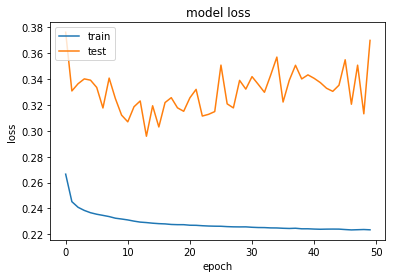

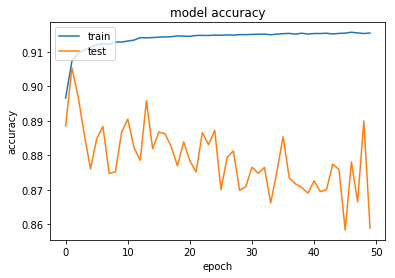

UNET ARCHITECTURE
-------------------------------------------------------------
Total num of training images: 3780
Max num of epochs: 50
Optimizer: ADAM
Batch size: 64
Loss function: Binary Cross-Entropy
Validation data percentage: 10
Early stoppping: Yes
-------------------------------------------------------------
#    Time sec      Tr_acc     Tr_loss      Vl_acc     Vl_loss
-------------------------------------------------------------
0   157.185700    0.896600    0.266500    0.888600    0.376321
1   155.735700    0.907300    0.245200    0.905400    0.330903
2   156.099200    0.909600    0.240800    0.897100    0.336482
3   155.968800    0.910600    0.238400    0.886100    0.340225
4   156.191300    0.911300    0.236700    0.876100    0.339235
5   155.956900    0.912100    0.235500    0.884900    0.333602
6   155.872900    0.912300    0.234600    0.888400    0.317715
7   155.985700    0.912200    0.233700    0.874800    0.340838
8   156.029400    0.912900    0.232400    0.875200    

In [15]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 50;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [1]:
# Evaluate the model
model = load_model('model-extra256layer+moredata-10Feb2019.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset_Test/testing_data/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset_Test/ground_truth/'
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = ABD_PATH + abd_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MSK_PATH + msk_ids[0]
img = imread(path)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + abd_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MSK_PATH + msk_ids[n]
    img = imread(path)
    if n in range(899,977):
        img = img[:,:,1]
        
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))
   
X = dat[:,0:9]
Y = dat[:,9]
Y = (Y > 0).astype(np.uint8) 

NameError: name 'load_model' is not defined

In [17]:
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

47574033/47574033 [==============================] - 2444s 51us/step

acc: 95.75%
